# Resampling Methods

This notebook follows ISLR chapter 5 which is about using resampling methods to verify our analytics approach and includes the following topics:
* Validation Set
* Leave-One-Out Cross Validation (LOOCV)
* K-fold Cross Validation
* Bias-Variance Tradeoff for K-fold Cross Validation
* Cross-Validation in Classification Problems
* Bootstrap
* Applied Cross Validation on ISLR Auto Dataset

## Resampling

Repeatedly sampling data from a training data set and refitting our model to gauge if the fitted models differ. Training models this way gives us more insight into a model's performance. The two most commonly used resampling methods are:

1. Cross Validation (CV): Used to evaluate the test error of the model or to select the level of flexibility of a model.
    * Evaluating model performance is known as ***model assessment***
    * Selecting the proper level of flexibility is known as ***model selection***
2. Bootstrap: Measure the accuracy of a parameter estimate of a learning method

## Training Error and Test Error

***Test Error***: The average error obtained from using a model to make a prediction on new data.

***Training Error:*** The average error obtained from using a model to make predictions against the training set of data.

We always evaluate model performance using the test error.

## Validation Set

One way to evaluate Training/Test error is to split the data into a training and test (or hold-out) dataset. Our modeling approach follows these steps:

1. Divide data into training and test set***
2. Fit model on training dataset
3. Use fitted model to predict the responses for the data points in the test set
4. Evaluate model performance using a measure of error like MSE

***If comparing multiple models it is best to divide data into a training/test/validation set, comparing different models against the test dataset, and evaluating the final model chosen against the validation set

<img src="Training_Test.PNG">

## Applying validation set approach to ISLR `Default` dataset

In [2]:
library(ISLR)
data(Default)

In [3]:
spec <- c(train = .8, test = .2)

g <- sample(cut(
  seq(nrow(Default)), 
  nrow(Default)*cumsum(c(0,spec)),
  labels = names(spec)
))

split_data_set <- split(Default, g)
attributes(split_data_set)

$names
[1] "train" "test"

In [4]:
sapply(split_data_set, nrow)/nrow(Default)

train  test 
  0.8   0.2

Now that we have split the dataset into a training and a test set we can proceed to train a machine learning model on the training set and evaluate model performance on the test set.

Alternatively, we could split our data into training, test, and validation sets if we are evaluating more then one model. We train our prospective models on the training dataset, compare model performance on the test dataset, and finally evaluate the chosen model's "true" predictive capability on the validation set.

In [5]:
spec <- c(train = .7, test = .2, validation=.1)

g <- sample(cut(
  seq(nrow(Default)), 
  nrow(Default)*cumsum(c(0,spec)),
  labels = names(spec)
))

split_data_set <- split(Default, g)
attributes(split_data_set)

$names
[1] "train"      "test"       "validation"

In [6]:
sapply(split_data_set, nrow)/nrow(Default)

train       test validation 
       0.7        0.2        0.1

## Drawbacks of Validation Set Approach

While easy to understand and implement, the validation set appproach suffers from a few issues:

* By nature, splitting the data into two datasets is highly variable in the sense that our validation test error estimate is contingent upon which observations were included in the training and validation sets
* Since one set of data is used to fit the model, the test set error may tend to over-estimate the true test error of the model because it is biased based on which observations were being tested on

***Cross Validation*** addresses both of these issues.

## Leave-One-Out Cross Validation (LOOCV)

LOOCV also uses a training and a test dataset, but is structured as follows:
* Only one observation $(x_{1} \, , \, y_{1})$ is used for the test set
* All other $(n-1)$ observations $\left \{ (x_{2} \, , \, y_{2}) \, , \, \ldots \, , \, (x_{n} \, , \, y_{n}) \right \}$ are used to train the model
* A prediction $\hat{y_{1}}$ is made on the test datapoint $x_{1}$
* Calculate the error term, for example $MSE_{1}=(y_{1} - \hat{y_{1}})^{2}$
    * This error term is an approximately unbiased estimate for the test error
    * However, this test error is highly variable as it is made up of only one data point!

To minimize the variance associated with this method, we repeat the whole procedure using all $n$ data points to come up with $MSE_{1} \, , \, \ldots \, , \, MSE_{n}$

The LOOCV estimate for the test MSE is the average of these $n$ MSEs:

$$
CV_{(n)} = \frac{1}{n}\sum_{i=1}^{n}MSE_{i}
$$

<img src="LOOCV.PNG">

## Applying LOOCV approach to ISLR `Default` dataset

In [7]:
if (!require(boot)) install.packages("boot")
library(boot)

Loading required package: boot


help(cv.glm)

In [8]:
head(Default,3)

default,student,balance,income
No,No,729.5265,44361.63
No,Yes,817.1804,12106.13
No,No,1073.5492,31767.14


In [9]:
Default$dft <- ifelse(Default$default == "Yes", 1, 0)

In [10]:
head(Default,3)

default,student,balance,income,dft
No,No,729.5265,44361.63,0
No,Yes,817.1804,12106.13,0
No,No,1073.5492,31767.14,0


reference: https://gerardnico.com/lang/r/cross_validation#leave-one-out

Let's train a model with a quantitative response variable to demonstrate LOOCV. Later we'll apply the exact same logic to a classification problem.

In [11]:
glm.fit <- glm(balance~dft+income, data=Default)

#LOOCV
loocv <- cv.glm(Default,glm.fit)

We access the `delta` attribute of the loocv object returned to get the measure of $CV_{(n)} = \frac{1}{n}\sum_{i=1}^{n}MSE_{i}$
* First term is our MSE
* Second term is the bias corrected MSE

loocv$delta

## Pros and Cons of Using LOOCV

* Pros:
    * LOOCV has far less bias then the training/test approach since it uses $(n-1)$ observations to train the model
    * After repeating the process for all $n$ data points we end up with a measure of model performance that has used all data points to train/test the model
    * LOOCV always gives the same results, unlike the training/test approach
* Cons:
    * Computationally expensive since we must do $n$ model runs
    * Often infeasible for very large datasets or for very computationally intense model runs

## K-fold CV

Another variant of cross validation is ***K-fold CV***:
* Divide the data into $k$ groups or folds of about the same size
* Training the model on $(k-1)$ folds, testing on the hold out fold
* Measuring the model error using a measure like MSE
* Repeating the procedure $k$ times yielding $k$ estimates of the test error $MSE_{1} \, , \, \ldots \, , \, MSE_{k}$
* k-fold CV estimate for the test MSE is the average of these $k$ MSEs:

$$
CV_{(k)} = \frac{1}{k}\sum_{i=1}^{k}MSE_{i}
$$

***LOOCV is a special case of K-fold CV where $k=n$***

<img src="k-fold.PNG">

K-fold CV is a better choice then LOOCV because we only need to perform $k$ model runs compared to $n$ model runs with LOOCV. This is advantageous with large datasets or complex model runs.

## Applying k-fold CV approach to ISLR `Default` dataset

help(cv.glm)

In [12]:
k_fold <- cv.glm(Default, glm.fit, K = 3)

We access the `delta` attribute of the k_fold object returned to get the measure of $CV_{(k)} = \frac{1}{k}\sum_{i=1}^{k}MSE_{i}$
* First term is our MSE
* Second term is the bias corrected MSE

In [13]:
k_fold$delta

[1] 200528.6 200490.3

## Pros and Cons of Using k-fold CV

* Pros:
    * Model is only fit $k$ time compared to $n$ times with LOOCV
    * After repeating the process for all $k$ folds we end up with a measure of model performance that has used all data points to train/test the model
* Cons:
    * Can still be computationally expensive since we must do $k$ model runs

## Bias-Variance Tradeoff with k-fold CV

* Since model is only fit $k$ times compared to $n$ times with LOOCV (where $k<n$), k-fold CV is computationally less expensive
* Believe it or not ***k-fold CV gives more accurate test error rate estimates than LOOCV***
    * This is due to the bias-variance tradeoff
    * LOOCV yields approximately unbiased estimates of the test error since each training set has (n-1) observations which is basically the whole dataset
    * The fact above makes LOOCV basically equivalent to the test/training approach when it comes to underestimating the true test error rate
    
Doing k-fold CV with $k=5$ or $k=10$ will lead to some level of bias since each test set contains $\frac{n}{k}$ observations and each training set contains $n-\frac{n}{k}=n\left(1-\frac{1}{k}\right)=n\frac{\left(k-1\right)}{k}$ observations.
* Training set size in k-fold CV is smaller than in LOOCV, but alot bigger than the test/training approach

From a test error bias reduction standpoint, ***LOOCV is preferred to k-fold CV***

However, ***LOOCV has higher test error rate variance than k-fold CV with $k<n$***
* Outputs from LOOCV are highly correlated with one another
* Due to the fact that the mean of many highly correlated quantities has higher variance than the mean of many quantities that are not highly correlated (k-fold CV)

LOOCV is in effect averaging the outputs of $n$ fitted models, each of which is trained on an almost identical set of data

In contrast, when we perform k-fold CV with $k<n$, we are averaging the outputs of $k$ fitted models that are somewhat less correlated with each other since the overlap between training sets in each model is smaller
* Use $k=5$ or $k=10$ as a sweet spot tradeoff between bias and variance

## Cross-validation in Classification Problems

We can use the exact same resampling methods discussed above in classification problems.The only thing that changes is the error term (by default we only look at the misclassification rate, but could just as easily extend this to other classification metrics like F1 score):

$$
CV_{(n)} = \frac{1}{n}\sum_{i=1}^{n}Err_{i}
$$

where $ERR_{i} = I\,(y_{i} \neq \hat{y_{i}})$ i.e., $ERR_{i} = 1\: if\: (y_{i} \neq \hat{y_{i}})$ and 0 otherwise.

This formulation of the error term holds for the training/test approach, LOOCV, and k-fold CV.

<img src="CV Classification.PNG">

Charts above further demonstrate the need for cross-validation. It should be obvious that as the model gets more and more complex, the training data is fit better and better. This perceived high confidence in model fit to the training data can be very misleading as evidenced by the "U" shape of the test set in this case.

In [17]:
data(Auto)
set.seed(1234)

## Bootstrap

Bootstrap is a widely applicable and powerful tool to ***quantify the uncertainty*** associated with a given estimator or machine learning model.
* For example, bootstrap can be used to estimate the standard errors of the coefficients from a linear regression fit
* Bootstrap is powerful because we can find measures of variability that are not automatically output by statistical software
* See ISLR Page 195-197 for more details on lab below

## ISLR Section 5.3.4 Bootstrap Lab

Use bootstrap to *assess the variability of the estimates for β0 and β1, the intercept and slope terms for the linear regression model that uses `horsepower` to predict `mpg` in the `Auto` data set.*

First, create a simple function, `boot.fn`, which takes in the `Auto` data set as well as a set of indices for the observations, and returns the intercept and slope estimates for the linear regression model. We then apply this function to the full set of 392 observations in order to compute the esti- mates of β0 and β1 on the entire data set using the usual linear regression coefficient estimate formulas from Chapter 3

In [137]:
boot.fn=function(data,index)
{
    return(coef(lm(mpg~horsepower ,data=data,subset=index)))
}

In [138]:
boot.fn(Auto, index=1:nrow(Auto))

(Intercept)  horsepower 
 39.9358610  -0.1578447

With `boot.fn` in hand, we can now randomly sample with replacement from our dataframe to find the standard error associated with the linear regression coefficients $\beta_{0}$ and $\beta_{1}$.

In [139]:
boot.fn(Auto,sample(nrow(Auto),nrow(Auto),replace=T))

(Intercept)  horsepower 
 39.9781266  -0.1573209

In [140]:
boot.fn(Auto,sample(nrow(Auto),nrow(Auto),replace=T))

(Intercept)  horsepower 
 40.7303880  -0.1672269

Next, we use the `boot()` function to compute the standard errors of 1,000 bootstrap estimates for the intercept and slope terms.

In [141]:
boot(Auto ,boot.fn ,1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  1.125026e-02 0.868901124
t2* -0.1578447 -4.899628e-05 0.007489217

This indicates that the bootstrap estimate for SE(βˆ0) is 0.87, and that the bootstrap estimate for SE(βˆ1) is 0.0075. Let's compare these to the output from the `summary()` function called on a fitted `lm` model.

In [143]:
summary(lm(mpg~horsepower ,data=Auto))$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39.9358610,0.717498656,55.65984,1.220362e-187
horsepower,-0.1578447,0.006445501,-24.48914,7.031989e-81


Why are the values different? Is bootstrap not accurate? Actually the opposite is true in this case! The Std. Error returned by the `summary()` function makes the standard set of linear regression model assumptions about the coefficients. From ISLR page 196:

*For example, they depend on the unknown parameter σ2, the noise variance. We then estimate σ2 using the RSS. Now although the formula for the standard errors do not rely on the linear model being correct, the estimate for σ2 does. We see in Figure 3.8 on page 91 that there is a non-linear relationship in the data, and so the residuals from a linear fit will be inflated, and so will σˆ2. Secondly, the standard formulas assume (somewhat unrealistically) that the xi are fixed, and all the variability comes from the variation in the errors εi.*

***The bootstrap approach does not rely on any of these assumptions, and so it is likely giving a more accurate estimate of the standard errors of βˆ0 and βˆ1 than is the summary() function.***

## Applied Resampling Methods

Now let's apply the resampling methods to the ISLR `Auto` dataset.

In [18]:
head(Auto)

mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,1,buick skylark 320
18,8,318,150,3436,11.0,70,1,plymouth satellite
16,8,304,150,3433,12.0,70,1,amc rebel sst
17,8,302,140,3449,10.5,70,1,ford torino
15,8,429,198,4341,10.0,70,1,ford galaxie 500


### Applied Training/Test Set

In [19]:
spec <- c(train = .8, test = .2)

g <- sample(cut(
  seq(nrow(Auto)), 
  nrow(Auto)*cumsum(c(0,spec)),
  labels = names(spec)
))

split_data_set <- split(Auto, g)
attributes(split_data_set)

$names
[1] "train" "test"

In [20]:
auto_fit <- lm(mpg~horsepower, data=split_data_set$train)

reference:  https://stackoverflow.com/a/5234201

In [27]:
head(split_data_set$train[ , -which(names(Auto) %in% c("mpg"))])

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
2,8,350,165,3693,11.5,70,1,buick skylark 320
3,8,318,150,3436,11.0,70,1,plymouth satellite
4,8,304,150,3433,12.0,70,1,amc rebel sst
6,8,429,198,4341,10.0,70,1,ford galaxie 500
7,8,454,220,4354,9.0,70,1,chevrolet impala


### Test Set MSE

In [32]:
mean((split_data_set$test$mpg - predict(auto_fit, split_data_set$test))^2)

[1] 21.42393

### Quadratic & Cubic Regression

We can use the R function `poly` to estimate the test error for the quadratic and cubic regressions.

In [36]:
# quadratic regression
auto_fit2 <- lm(mpg~poly(horsepower,2), data=split_data_set$train)

In [37]:
mean((split_data_set$test$mpg - predict(auto_fit2, split_data_set$test))^2)

[1] 15.80707

In [38]:
# cubic regression
auto_fit3 <- lm(mpg~poly(horsepower,3), data=split_data_set$train)

In [39]:
mean((split_data_set$test$mpg - predict(auto_fit3, split_data_set$test))^2)

[1] 15.98021

Thus the test error rate for simple linear regression is $21.42$, quadratic regression is $15.81$, and cubic regression is $15.98$. This will change if we change the seed on the training/test set.

These test errors suggest quadratic regression as a fit is our best choice.

In [46]:
poly_Test <- integer(10)
for (i in 1:10) {
    temp_model <- lm(mpg~poly(horsepower,i), data=split_data_set$train)
    poly_Test[i] <- mean((split_data_set$test$mpg - predict(temp_model, split_data_set$test))^2)
}

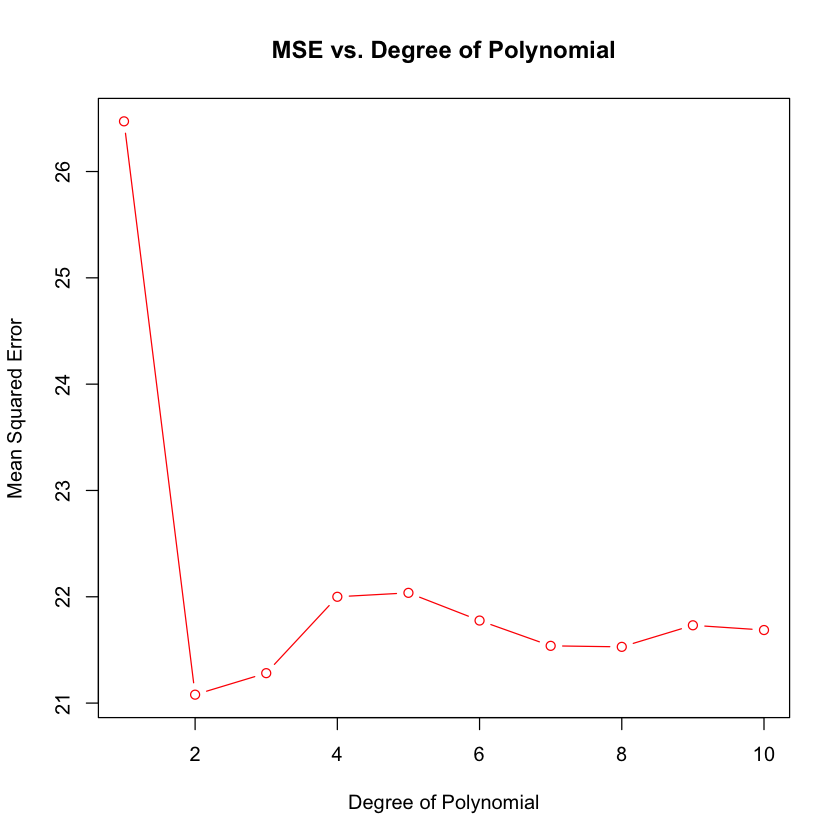

In [97]:
plot(poly_Test,
     type='b',
     col='red',
     xlab='Degree of Polynomial',
     ylab='Mean Squared Error',
     main='MSE vs. Degree of Polynomial')

The chart above shows the validation error estimates for a single training/test split.

In [74]:
poly_graphs <- vector("list", length = 6)
for (i in 1:6) {
    set.seed(sample(1:10000,1))
    poly_Test <- integer(10)
    spec <- c(train = .8, test = .2)

    g <- sample(cut(
      seq(nrow(Auto)), 
      nrow(Auto)*cumsum(c(0,spec)),
      labels = names(spec)
    ))

    split_data_set <- split(Auto, g)
    for (j in 1:10) {
        temp_model <- lm(mpg~poly(horsepower,j), data=split_data_set$train)
        poly_Test[j] <- mean((split_data_set$test$mpg - predict(temp_model, split_data_set$test))^2)
    }
    
    poly_graphs[[i]] <- poly_Test
}

In [95]:
color <- colors()[sample(1:600,6)]

Warning message in par(new = T):
“calling par(new=TRUE) with no plot”

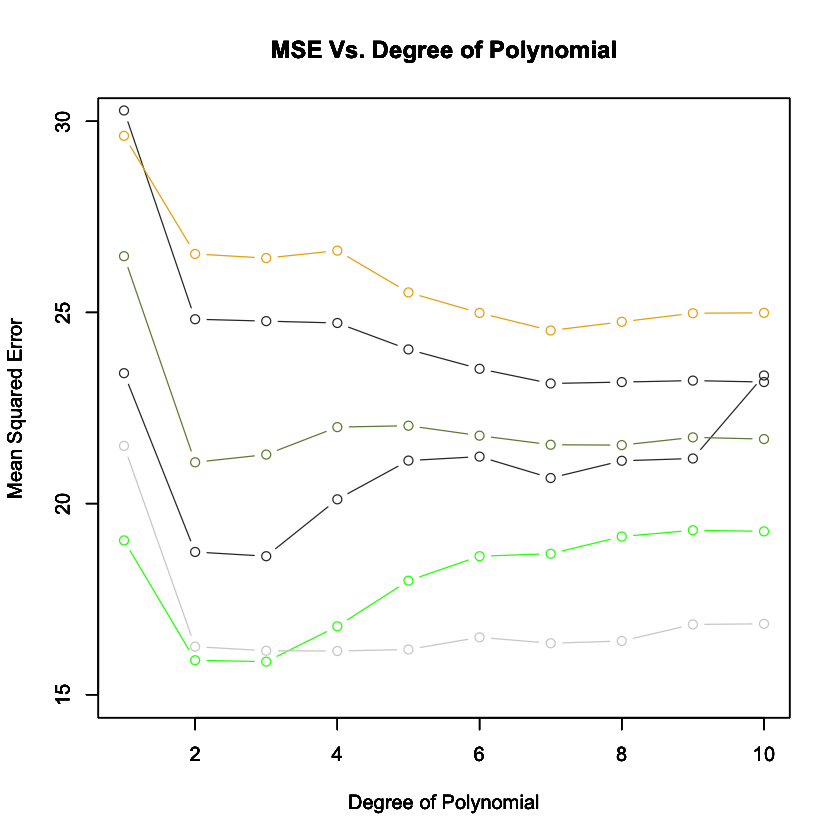

In [98]:
for (i in 1:6) {
  par(new=T)
  plot(poly_graphs[[i]],
       col=color[i],
       type='b',
       ylim=c(15,30),
       ylab="Mean Squared Error",
       xlab="Degree of Polynomial",
       main='MSE Vs. Degree of Polynomial')
}

Plot above shows the MSE vs. Degree of Polynomial for 6 different training/test splits. The "true" test error rate is somewhere in this solution plane. If we increase the number of splits, we should see some convergence:

In [99]:
l=100
poly_graphs <- vector("list", length = l)
for (i in 1:l) {
    set.seed(sample(1:10000,1))
    poly_Test <- integer(10)
    spec <- c(train = .8, test = .2)

    g <- sample(cut(
      seq(nrow(Auto)), 
      nrow(Auto)*cumsum(c(0,spec)),
      labels = names(spec)
    ))

    split_data_set <- split(Auto, g)
    for (j in 1:10) {
        temp_model <- lm(mpg~poly(horsepower,j), data=split_data_set$train)
        poly_Test[j] <- mean((split_data_set$test$mpg - predict(temp_model, split_data_set$test))^2)
    }
    
    poly_graphs[[i]] <- poly_Test
}

In [100]:
color <- colors()[sample(1:600,l)]

Warning message in par(new = T):
“calling par(new=TRUE) with no plot”

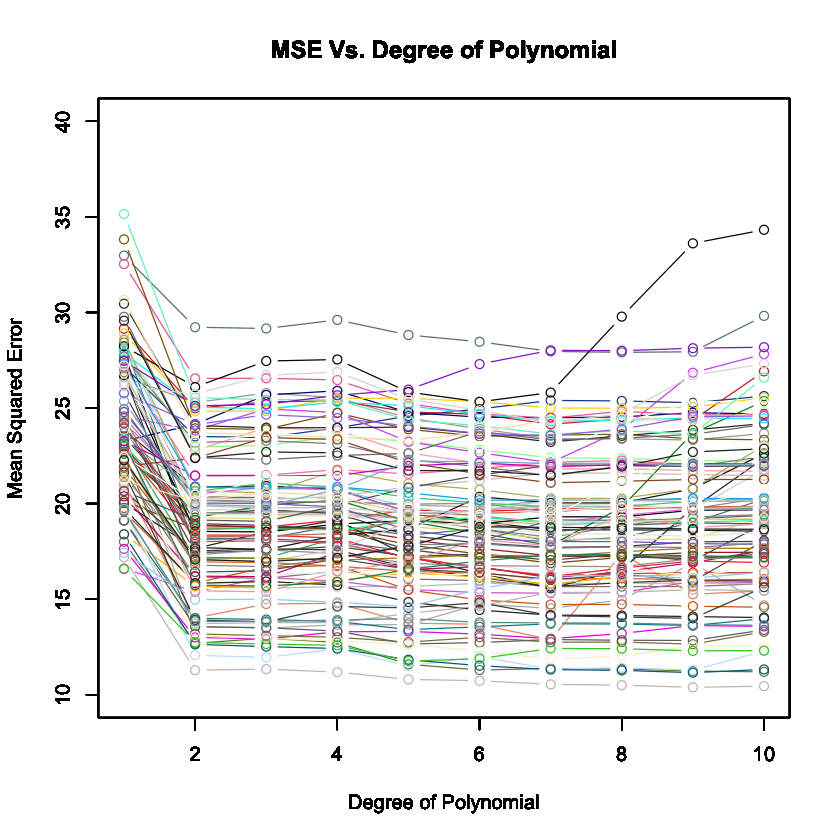

In [103]:
for (i in 1:l) {
  par(new=T)
  plot(poly_graphs[[i]],
       col=color[i],
       type='b',
       ylim=c(10,40),
       ylab="Mean Squared Error",
       xlab="Degree of Polynomial",
       main='MSE Vs. Degree of Polynomial')
}

Plot above shows why changing the number of training/test splits is not an efficient way to find an optimal solution. It should also highlight the inherent bias with using the training/test approach and the increased variance (y axis bounds are much wider then two plots above) associated with trying to pull out an aggregate measure for test error rate from a training/test approach.

These graphical results should motivate the reader to always try to use cross-validation techniques when possible!

## LOOCV ISLR `Auto`

For our next example, let's run the same regression as above, but performing LOOCV using the `cv.glm` function from the `boot` package.

In [107]:
glm.fit <- glm(mpg~horsepower,data=Auto)
loocv <- cv.glm(Auto, glm.fit, K = nrow(Auto))
loocv$delta

[1] 24.23151 24.23114

We access the `delta` attribute of the loocv object returned to get the measure of $CV_{(n)} = \frac{1}{n}\sum_{i=1}^{n}MSE_{i}$
* First term is our MSE
* Second term is the bias corrected MSE

## k-fold. CV ISLR `Auto`

For our next example, let's run the same regression as above, but performing k-fold CV (k=10) using the `cv.glm` function from the `boot` package.

In [108]:
glm.fit <- glm(mpg~horsepower,data=Auto)
kfold <- cv.glm(Auto, glm.fit, K = 10)
kfold$delta

[1] 24.14733 24.13655

We access the `delta` attribute of the k_fold object returned to get the measure of $CV_{(k)} = \frac{1}{k}\sum_{i=1}^{k}MSE_{i}$
* First term is our MSE
* Second term is the bias corrected MSE

# Fin!

In this notebook, I examined different resampling methods including:
* Training/test set approach
* LOOCV
* k-fold CV
* bootstrap